In [1]:
import jax.numpy as jnp
import jax.random as jrandom

import matplotlib.pyplot as plt
import pandas as pd
from jax import jit, grad, jacfwd, jacrev



from scipy.stats import linregress

from tqdm import tqdm
import pickle

import numpy as np

from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

## Here we are going to compute the derivatives of each term

In [191]:
dim = 3
N = dim

jrandom_key = jrandom.PRNGKey(1)
jrandom_key, subkey = jrandom.split(jrandom_key)
U = jrandom.normal(subkey, shape=(dim, N))
U /= jnp.linalg.norm(U, axis=0)
D_half = jnp.diag(jnp.linspace(1, 10, dim))
D = D_half**2
a = jnp.linspace(5, 15, dim)
A = jnp.diag(a)
U_inv = jnp.linalg.inv(U)
U_inv_T = U_inv.T
A_inv = jnp.diag(1/a)

In [194]:
first_A_term = lambda A: jnp.linalg.norm(D_half @ U_inv_T @ jnp.diag(A.reshape(dim, dim)))**2
g_first_A_term = lambda A: grad(first_A_term)(A).reshape(dim, N)

analytic_g_first_A = lambda A: 2 * U_inv @ D @ U_inv_T @ jnp.outer(a, jnp.ones(dim))

print("Exact g", g_first_A_term(A.flatten()))
print("Analytic g", analytic_g_first_A(A))

Exact g [[12570.47427468     0.             0.        ]
 [    0.         -6265.11970908     0.        ]
 [    0.             0.          7523.56219726]]
Analytic g [[12570.47427468 12570.47427468 12570.47427468]
 [-6265.11970908 -6265.11970908 -6265.11970908]
 [ 7523.56219726  7523.56219726  7523.56219726]]


In [185]:
second_A_term = lambda A: jnp.linalg.norm(jnp.linalg.inv(A.reshape(dim, dim)) @ U_inv @ D_half, "fro")**2
g_second_A_term = lambda A: grad(second_A_term)(A).reshape(dim, N)

analytic_g_second_A = lambda A_inv: -2 *  U_inv @ D @ U_inv.T @ A_inv**3

print("Exact g", g_second_A_term(A.flatten()))
print("Analytic g", analytic_g_second_A(A_inv))

Exact g [[-12.11622848   3.57635372  -2.47799392]
 [  1.78817686  -0.69122928   0.38697646]
 [ -0.82599797   0.25798431  -0.17149571]]
Analytic g [[-12.11622848   0.89408843  -0.27533266]
 [  7.15270744  -0.69122928   0.17198954]
 [ -7.43398175   0.58046469  -0.17149571]]


In [189]:
third_A_term = lambda A: jnp.linalg.norm(D_half @ U_inv_T @ jnp.diag(jnp.linalg.inv(A.reshape(dim, dim))))**2
g_third_A_term = lambda A: grad(third_A_term)(A).reshape(dim, N)

analytic_g_third_A = lambda A: - 2 * U_inv @ D @ U_inv_T @ jnp.outer(1/a, 1/a**2) 

print("Exact g", g_third_A_term(A.flatten()))
print("Analytic g", analytic_g_third_A(A_inv))

Exact g [[-11.01786867   0.           0.        ]
 [  0.           1.48392404   0.        ]
 [  0.           0.          -0.73950938]]
Analytic g [[-11.01786867  -2.75446717  -1.22420763]
 [  5.93569615   1.48392404   0.65952179]
 [ -6.65558441  -1.6638961   -0.73950938]]


In [112]:
first_term = lambda U_inv: jnp.linalg.norm(D_half @ U_inv.reshape(dim, N).T @ a)**2
g_first_term = lambda U_inv: grad(first_term)(U_inv).reshape(dim, N)

analytic_g_first = lambda U_inv: 2 * np.outer(a, a) @ U_inv.reshape(dim, N) @ D_half**2

print("Exact g", g_first_term(U_inv.flatten()))
print("Analytic g", analytic_g_first(U_inv.flatten()))



Exact g [[-1.00583772e+01 -4.72979961e+03 -2.74042177e+03]
 [-2.01167544e+01 -9.45959923e+03 -5.48084355e+03]
 [-3.01751316e+01 -1.41893988e+04 -8.22126532e+03]]
Analytic g [[-1.00583772e+01 -4.72979961e+03 -2.74042177e+03]
 [-2.01167544e+01 -9.45959923e+03 -5.48084355e+03]
 [-3.01751316e+01 -1.41893988e+04 -8.22126532e+03]]


In [121]:
second_term = lambda U_inv: jnp.linalg.norm(A_inv @ U_inv.reshape(dim, dim) @ D_half, "fro")**2 
g_second_term = lambda U_inv: grad(second_term)(U_inv).reshape(dim, N)

analytic_g_second = lambda U_inv: 2 * A_inv**2 @ U_inv.reshape(dim, dim) @ D

print("Exact g", g_second_term(U_inv.flatten()))
print("Analytic g", analytic_g_second(U_inv.flatten()))

Exact g [[-0.07349626 -0.55062823 -8.24363717]
 [-0.03919891 -0.14805724 -0.14729715]
 [ 0.01374052 -0.21602197  0.18656813]]
Analytic g [[-0.07349626 -0.55062823 -8.24363717]
 [-0.03919891 -0.14805724 -0.14729715]
 [ 0.01374052 -0.21602197  0.18656813]]


In [128]:
e_idx = 0 
e_vec = np.zeros(dim)
e_vec[e_idx] = 1
e_vec = jnp.array(e_vec)
constraint_term = lambda U_inv: jnp.linalg.norm(jnp.linalg.inv(U_inv.reshape(dim, dim))[:, e_idx])**2 
g_constraint_term = lambda U_inv: grad(constraint_term)(U_inv).reshape(dim, N)

analytic_g_constraint = lambda U: - 2 * U.T @ U @ jnp.outer(e_vec, e_vec) @ U.T

print("Exact g", g_constraint_term(U_inv.flatten()))
print("Analytic g", analytic_g_constraint(U))

Exact g [[-0.11173332  0.30075564  1.9740977 ]
 [ 0.05162012 -0.13894728 -0.91202118]
 [-0.00499371  0.01344171  0.08822861]]
Analytic g [[-0.11173332  0.30075564  1.9740977 ]
 [ 0.05162012 -0.13894728 -0.91202118]
 [-0.00499371  0.01344171  0.08822861]]


In [119]:
import numpy as np

In [ ]:
def createS(ts, dim):
    S = []
    for c in range(dim):
        tmp_S = []
        for r in range(dim):
            curr_term = 1
            if len(tmp_S) > 0:
                curr_term = tmp_S[-1] / np.cos(ts[c][r-1]) * np.sin(ts[c][r - 1])
            if r < dim - 1:
                curr_term *= np.cos(ts[c][r])
                
            tmp_S.append(curr_term)
        S.append(tmp_S)
    S = np.array(S).T
    return S

def createPartialS(ts, dim, r_theta, c_theta):
    
    S = []
    for c in range(dim):
        tmp_S = []
        for r in range(dim):
            if c != c_theta:
                tmp_S.append(0)
                continue
                
            curr_term = 1
            if len(tmp_S) > 0:
                if r == r_theta + 1:
                    curr_term = - tmp_S[-1] / np.sin(ts[c][r - 1]) * np.cos(ts[c][r - 1])
                else:
                    curr_term = tmp_S[-1] / np.cos(ts[c][r - 1]) * np.sin(ts[c][r - 1])
            if r < dim - 1:
                if r == r_theta:
                    curr_term *= -np.sin(ts[c][r])
                else:
                    curr_term *= np.cos(ts[c][r])
                
            tmp_S.append(curr_term)
            
        S_to_append = np.zeros(dim)
        S_to_append[r_theta:] = tmp_S[r_theta:]
        S.append(S_to_append)
    S = np.array(S).T
    return S

In [ ]:
dim = 5
A = np.diag(np.linspace(1, 5, dim))
D = np.diag(np.linspace(5, 10, dim))
ts = np.random.normal(size=(dim, dim-1))

In [ ]:
print("First term")
h = 0.00001
first_term = lambda ts: np.linalg.norm(D.dot(np.linalg.inv(createS(ts, dim)).T).dot(np.diag(A)))**2

r, c = 1, 1
h_ts = ts.copy()
h_ts[c][r] += h
print("FD Estimate", (first_term(h_ts) - first_term(ts))/h)

In [ ]:
S = createS(ts, dim)
S_inv = np.linalg.inv(S)
p_S = createPartialS(ts, dim, r, c)
-np.trace(2 * ((D**2).dot(S_inv.T).dot(np.outer(np.diag(A), np.diag(A)))).dot(S_inv).dot(p_S).dot(S_inv))

In [ ]:
print("Second term")
h = 0.00001
second_term = lambda ts: np.linalg.norm(D.dot(np.linalg.inv(createS(ts, dim)).T).dot(1/np.diag(A)))**2

r, c = 1, 1
h_ts = ts.copy()
h_ts[c][r] += h
print("FD Estimate", (second_term(h_ts) - second_term(ts))/h)

S = createS(ts, dim)
S_inv = np.linalg.inv(S)
p_S = createPartialS(ts, dim, r, c)
print("analytic", -np.trace(2 * ((D**2).dot(S_inv.T).dot(np.outer(1/np.diag(A), 1/np.diag(A)))).dot(S_inv).dot(p_S).dot(S_inv)))

In [ ]:
print("Third term")
h = 0.00001
third_term = lambda ts: np.linalg.norm(np.linalg.inv(A).dot(np.linalg.inv(createS(ts, dim))).dot(D), "fro")**2

r, c = 1, 1
h_ts = ts.copy()
h_ts[c][r] += h
print("FD Estimate", (third_term(h_ts) - third_term(ts))/h)

S = createS(ts, dim)
S_inv = np.linalg.inv(S)
p_S = createPartialS(ts, dim, r, c)
print("analytic", -np.trace(2 * ((D**2).dot(S_inv.T).dot(np.linalg.inv(A)**2).dot(S_inv).dot(p_S).dot(S_inv))))



In [ ]:
f = lambda S: np.linalg.norm(D.dot(S).dot(np.diag(A)))**2

r, c = 3, 2
S_inv = np.linalg.inv(S)
# tmp_S_inv = S_inv.copy()



res = np.zeros(shape=(dim, dim))
for c in range(dim):
    for r in range(dim):
        tmp_S_inv = S_inv.copy()
        tmp_S_inv[c][r] += h
    
        res[c][r] = (f(tmp_S_inv.T) - f(S_inv.T))/h
res

In [ ]:
(2 * ((D**2).dot(S_inv.T).dot(np.outer(np.diag(A), np.diag(A))))).T

In [ ]:
D = jnp.diag(jnp.array([1, 2]))

A = jnp.array([2, 3])

def f(X):
    X = jnp.linalg.inv(X.reshape(2, 2))

    return jnp.linalg.norm(D.dot(X.T.dot(A))) + jnp.linalg.norm(D.dot(X.T.dot(1/A)))

gf = grad(f)




In [ ]:
t = np.pi/4
X = jnp.array([[np.cos(t), np.sin(t)], [-np.sin(t), np.cos(t)]])
print(X.T.dot(X))
X = X.flatten()

gf(X)

In [ ]:
min_val = float("inf")
min_S = None
for _ in range(1000):
    X = np.random.normal(size=(2, 2))
    X /= jnp.linalg.norm(X, axis=0)
    X = X.flatten()
    
    curr_val = f(X)
    if curr_val < min_val:
        min_val = curr_val
        min_S = X
    

In [ ]:
min_val

In [ ]:
S = min_S.reshape(2, 2)
print(S)
S.T.dot(S)

In [ ]:
np.linalg.eig(S.T.dot(S))

In [ ]:
S.T.dot(A)

In [ ]:
A

In [ ]:
def createU(dim):
    res = [jnp.ones(dim)/jnp.linalg.norm(jnp.ones(dim))]
    for i in range(dim-1):
        tmp = np.zeros(dim)
        tmp[:i+1] = 1
        tmp[i + 1] = -(i + 1)
        tmp /= np.linalg.norm(tmp)
        res.append(tmp)
        
    return jnp.array(res).T
    


In [ ]:
dim = 3
N = dim
D = jnp.diag(jnp.linspace(1, 10, dim))
sig = 1

l = loss_getter(dim, N, D, sig)
g_l = grad(l)

In [ ]:
res = []
jrandom_key = jrandom.PRNGKey(0)
eps = 1e-4
for _ in range(1000):
    jrandom_key, subkey = jrandom.split(jrandom_key)
    res.append(jnp.linalg.norm(g_l(opt_S.T.flatten() + eps*jrandom.normal(subkey, shape=(9,)))))

In [ ]:
U = createU(dim)
S = jnp.linalg.inv(D**(0.5)).dot(U)

print(S)
for a in jnp.linspace(1, 10, 10):
    curr_S = a * S
    
    print(a)
    print(g_l(curr_S.T.flatten()))
    print(l(curr_S.T.flatten()))
    print()

In [4]:
def helper_linesearch(f, g, c1, c2):

    def helper(X, search_direction):
        f0 = f(X)
        f1 = g(X)
        dg = jnp.inner(search_direction, f1)

        def armijo_rule(alpha):
            return f(X + alpha * search_direction) > f0 + c1*alpha*dg
        
        def armijo_update(alpha):
            return c2*alpha
            
        alpha = 1
        while armijo_rule(alpha):
            alpha = armijo_update(alpha)


        return alpha

    return helper

def loss_getter(dim, N, H, sig):
    def helper(X):
    
#         S = X.reshape(N, dim).T

#         SS = S.dot(S.T)

#         SS_inv = jnp.linalg.inv(SS)
#         S_sum = jnp.sum(S, axis=1)  

#         first_term = 10*S.dot(jnp.diag(S.T.dot(H.dot(S))))
#         first_term = jnp.linalg.norm(SS_inv.dot(first_term))**2
        
#         second_term = 0#*jnp.linalg.norm(SS_inv.dot(S), ord="fro")**2        
#         third_term = S_sum.T.dot(SS_inv.dot(SS_inv.dot(S_sum)))  
        
#         return  + sig**2*(second_term + third_term)

        S = X.reshape(N, dim).T
        
        S_inv = jnp.linalg.inv(S)
        
        first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
        second_term = jnp.linalg.norm(S_inv, ord="fro")**2
        third_term = S_inv.T @ jnp.ones(dim)
        third_term = jnp.linalg.norm(third_term)**2
        
        return jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term)

    return helper

def optimize_uncentered_S(H, sig, max_steps=15, jrandom_key=None, x_curr=None):
    
    dim = H.shape[0]
    N = dim
    
    H = (H + H.T) / 2. # to combat numerical inaccuracies. 
    D, U = jnp.linalg.eig(H)
    U = jnp.real(U)

    # print("D", repr(jnp.real(D)))
    D = jnp.diag(D)

    if x_curr is None:
        if jrandom_key is None:
            x_curr = jnp.diag(jnp.sqrt(sig / jnp.abs(jnp.diag(D)))).flatten()
            pass
        else:
            x_curr = jrandom.normal(jrandom_key, shape=(dim * dim,)) * 0.1
        
    
        
#     x_curr = jnp.array([ 0.05915076, -0.0340726 ,  0.01818264, -0.31835382,
#              -0.05880886, -0.04264622,  0.01758689, -0.35780406,
#              -0.00296912,  0.07070069,  0.02147466, -0.25530761,
#               0.00104251,  0.00597147, -0.09367059, -0.20932359])
    
    l = loss_getter(dim, N, D, sig)
    g_l = grad(l)
    h_l = jacfwd(g_l)
    linesearch = helper_linesearch(l, g_l, c1=0.01, c2=0.9)

    eps = 1e-20

    res = []
    res_x = []

    for t in tqdm(range(max_steps)):
        
#         D = jnp.sqrt(jnp.linalg.inv(H))
#         tmp = x_curr.reshape(N, dim).T
#         tmp = D.dot(tmp")
#         tmp = tmp.dot(jnp.diag(1/jnp.linalg.norm(tmp, axis=0))) * jnp.mean(jnp.linalg.norm(tmp, axis=0))
#         tmp = jnp.linalg.inv(D).dot(tmp)
#         x_curr = tmp.T.flatten()
#         x_curr = np.array(x_curr.reshape(N, dim).T)
#         x_curr[0] = np.mean(x_curr[0])
#         x_curr = jnp.array(x_curr).T.flatten()
        
        res.append(l(x_curr))
#         res_x.append(U.dot(x_curr.reshape(N, dim).T)) # TURN ON FOR HISTORY 

        curr_grad = g_l(x_curr)
    
        # print(curr_grad)
        curr_hess = h_l(x_curr)#+ 0.1*jnp.eye(25)
        search_direction = -jnp.linalg.inv(curr_hess) @ curr_grad #+ np.random.normal(size=(25))*0.1
#         search_direction = -curr_grad + np.random.normal(size=(25))*0.1

        if jnp.linalg.norm(curr_grad) < eps:
            break    

        alpha = linesearch(x_curr, search_direction)

        S = x_curr.reshape(N, dim).T

        SS = S.dot(S.T)

        x_curr += alpha*search_direction 
    
    return U.dot(x_curr.reshape(N, dim).T), res

In [38]:
dim = 5
N = dim
D = jnp.diag(jnp.linspace(1, 1000, dim))
# sig = 1
# D = jnp.array([[ 6.96867074e+03+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
#                0.00000000e+00+0.j,  0.00000000e+00+0.j],
#              [ 0.00000000e+00+0.j, -5.65090364e+03+0.j,  0.00000000e+00+0.j,
#                0.00000000e+00+0.j,  0.00000000e+00+0.j],
#              [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  3.30117392e+01+0.j,
#                0.00000000e+00+0.j,  0.00000000e+00+0.j],
#              [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
#                8.67518225e+00+0.j,  0.00000000e+00+0.j],
#              [ 0.00000000e+00+0.j,  0.00000000e+00+0.j,  0.00000000e+00+0.j,
#                0.00000000e+00+0.j, -3.02376833e+00+0.j]])
sig = 1 #0.00016666666666666666

l = loss_getter(dim, N, D, sig)
g_l = grad(l)

In [436]:
jrandom_key = jrandom.PRNGKey(10)
jrandom_key, subkey = jrandom.split(jrandom_key)
opt_S, l_hist = optimize_uncentered_S(D, sig=sig, max_steps=10, jrandom_key=subkey, x_curr=opt_S.T.flatten())

100%|██████████| 10/10 [00:07<00:00,  1.15it/s]


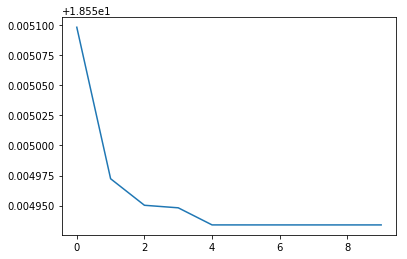

In [437]:
plt.plot(l_hist)
# plt.yscale("log")

In [438]:
g_l(opt_S.T.flatten())

DeviceArray([ 1.28441475e-08, -2.59858237e-08, -8.55163584e-09,
             -1.02133330e-08,  8.94890251e-08,  1.56628222e-09,
             -1.61076357e-07,  3.84689651e-08,  6.52281494e-07,
              8.09353982e-08,  9.99914240e-09,  5.20393244e-08,
              3.20310911e-08, -2.14833609e-08, -2.53389786e-07,
              9.27050214e-09, -2.77893855e-08,  3.84702519e-08,
             -2.43560111e-07,  1.40196478e-07,  2.01159116e-08,
              7.27566620e-08,  2.93866894e-07,  7.29218015e-08,
              1.75050417e-07], dtype=float64)

In [404]:
def get_multi_spherical(M):
    res = []
    prev = jnp.ones(len(M))
    for i in range(len(M) - 1):
        curr_m = M[i]
        curr_m = curr_m / prev
            
        res.append(jnp.arccos(curr_m))
        prev *= jnp.sin(res[-1])
    
    return jnp.array(res)


print("A \n", get_multi_spherical(-A))
print("B \n", get_multi_spherical(B))
print("C \n", get_multi_spherical(C))

A 
 [[2.03444394 2.03444394 2.03444394 2.03444394 2.03444394]
 [1.12213326 0.86034682 1.53067561 2.19503784 2.1430926 ]
 [2.4060512  1.40352441 0.57211272 1.93113485 1.58521161]
 [1.19886772 2.06453855 0.74428357 0.7929425  2.81530496]]
B 
 [[2.03444394 2.03444394 2.03444394 2.03444394 2.03444394]
 [1.58035738 0.91204486 2.03075562 1.05003246 2.28656864]
 [0.49395874 1.66397923 2.31533068 1.92496785 1.43627884]
 [1.82238635 2.38873858 2.27941033 0.3024852  1.09162902]]
C 
 [[2.03444394 2.03444394 2.03444394 2.03444394 2.03444394]
 [0.86937093 2.10415196 0.98844627 2.07019392 1.78029836]
 [1.9400284  1.39822582 0.89243964 1.05378383 2.58436577]
 [1.43360404 0.06076004 1.59691576 2.6695567  2.06975822]]


In [6]:
C = jnp.array([[-0.4472136 , -0.4472136 , -0.4472136 , -0.4472136 ,
               -0.4472136 ],
              [ 0.57718034, -0.45474982,  0.49192436, -0.42833831,
               -0.18601657],
              [-0.24659302,  0.13225447,  0.46875384,  0.38810881,
               -0.7425241 ],
              [ 0.08714827,  0.7573563 , -0.01518982, -0.60792455,
               -0.22139019],
              [ 0.63123681,  0.04607368, -0.58142027,  0.31036363,
               -0.40625385]])

In [12]:
ZC = jnp.diag(jnp.array([10.43398411,  0.26575781,  0.22358633,  0.20206671,
               0.18805993]))

C.T @ ZC @ jnp.diag(jnp.linspace(1, 1000, 5)) @ ZC @ C

DeviceArray([[43.51963602, 19.35973774, 10.88921759, 20.30648493,
              14.79295034],
             [19.35973774, 43.5196361 , 18.06320501, 12.90913535,
              15.01631263],
             [10.88921759, 18.06320501, 43.51963607, 16.49480532,
              19.9011626 ],
             [20.30648493, 12.90913535, 16.49480532, 43.51963615,
              15.63796467],
             [14.79295034, 15.01631263, 19.9011626 , 15.63796467,
              43.51963629]], dtype=float64)

In [ ]:
first_term = S_inv.T @ jnp.diag(S.T @ H @ S)
second_term = jnp.linalg.norm(S_inv, ord="fro")**2
third_term = S_inv.T @ jnp.ones(dim)
third_term = jnp.linalg.norm(third_term)**2

return jnp.linalg.norm(first_term)**2 + sig**2 * (second_term + third_term)

In [58]:
S = ZC @ C
S_inv = jnp.linalg.inv(S)
first_term = S_inv.T @ jnp.diag(S.T @ D @ S)
print(jnp.linalg.norm(first_term)**2)
print(jnp.linalg.norm(S_inv, ord="fro")**2)



86.98415813871
86.93823345694823


In [59]:
jnp.sum(1/jnp.diag(ZC**2))

DeviceArray(86.93823333, dtype=float64)

In [52]:
a**2 / ZC[0, 0]**2 * 5

DeviceArray(86.98415827, dtype=float64)

In [66]:
a = jnp.sum(ZC**2 @ jnp.diag(jnp.linspace(1, 1000, 5))) / 5
a

DeviceArray(43.51963572, dtype=float64)

In [24]:
C_inv = jnp.linalg.inv(C)
print(jnp.linalg.norm(jnp.linalg.inv(ZC) @ C_inv.T @ jnp.ones(dim)))

0.21430624499959866


In [42]:
l((ZC @ C).T.flatten())

DeviceArray(173.96831876, dtype=float64)

In [61]:
a**2 / ZC[0, 0]**2 * 5 + jnp.sum(1/jnp.diag(ZC**2)) + 1/ZC[0, 0]**2 * 5

DeviceArray(173.96831876, dtype=float64)

In [88]:
test_func = lambda ZT: (jnp.sum(ZT @ D))**2  #+ 1/(jnp.max(ZT)) * 5
print(test_func(ZC**2))
jnp.diag(grad(test_func)(ZC**2)) / (5 * ZC[0, 0]**2)


47348.967327828854


DeviceArray([  0.79949344, 200.47298031, 400.14646717, 599.81995404,
             799.4934409 ], dtype=float64)

In [100]:
jnp.sum(jnp.sqrt((jnp.diag(D)[1:])))

DeviceArray(97.22041339, dtype=float64)

In [92]:
[1, 1003/4, 1001/2, 3001/4, 1000]

[1, 250.75, 500.5, 750.25, 1000]

In [90]:
jnp.diag(ZC)**4 * D

DeviceArray([[1.18522467e+04, 0.00000000e+00, 0.00000000e+00,
              0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 1.25079198e+00, 0.00000000e+00,
              0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 1.25079193e+00,
              0.00000000e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
              1.25079197e+00, 0.00000000e+00],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
              0.00000000e+00, 1.25079196e+00]], dtype=float64)

In [86]:
(2 / (5 * ZC[0, 0]**2))

DeviceArray(0.00367417, dtype=float64)

In [89]:
(2 / ( ZC[0, 0]**2)) * a * jnp.diag(D)

DeviceArray([  0.79949344, 200.47298031, 400.14646717, 599.81995404,
             799.4934409 ], dtype=float64)

In [64]:
1/jnp.diag(ZC**2)**2

DeviceArray([8.43721888e-05, 2.00472984e+02, 4.00146489e+02,
             5.99819966e+02, 7.99493467e+02], dtype=float64)

In [7]:
C2 = jnp.array([[ 0.4472136 ,  0.4472136 ,  0.4472136 ,  0.4472136 ,
                0.4472136 ],
              [-0.57764951,  0.45484391, -0.49441266,  0.41932271,
                0.19789555],
              [ 0.26099774, -0.12920141, -0.46758444, -0.39786876,
                0.73365688],
              [ 0.06697981,  0.75570216,  0.00909401, -0.61390265,
               -0.21787333],
              [ 0.62746708,  0.07306336, -0.58037765,  0.29831603,
               -0.41846882]])

In [8]:
C - C2

DeviceArray([[-8.94427200e-01, -8.94427200e-01, -8.94427200e-01,
              -8.94427200e-01, -8.94427200e-01],
             [ 1.15482985e+00, -9.09593730e-01,  9.86337020e-01,
              -8.47661020e-01, -3.83912120e-01],
             [-5.07590760e-01,  2.61455880e-01,  9.36338280e-01,
               7.85977570e-01, -1.47618098e+00],
             [ 2.01684600e-02,  1.65414000e-03, -2.42838300e-02,
               5.97810000e-03, -3.51686000e-03],
             [ 3.76973000e-03, -2.69896800e-02, -1.04262000e-03,
               1.20476000e-02,  1.22149700e-02]], dtype=float64)

In [434]:
l((Z @ C).T.flatten())

DeviceArray(18.55509841, dtype=float64)

In [444]:
l(opt_S.T.flatten())

DeviceArray(18.55493391, dtype=float64)

In [400]:
jnp.sum(B)

DeviceArray(-2.23606801, dtype=float64)

In [9]:
Z = jnp.diag(jnp.array([3.57749375, 0.79727649, 0.69901923, 0.64158525, 0.60197686]))

In [ ]:
[[0.4472136 , 0.4472136 ,  0.4472136 ,  0.4472136 , 0.4472136 ],
[-0.38796791, -0.58332269, -0.03587543,  0.52277659, 0.48438944],
[ 0.5975515 , -0.11288845, -0.75139256,  0.2558909 , 0.0108386 ],
[-0.19651635,  0.31685345, -0.35591583, -0.47658445, 0.71216318],
[-0.50378014,  0.58872296, -0.32778972,  0.48383029,-0.24098339]]

In [ ]:
[-0.4472136 ,-0.4472136 ,-0.4472136, -0.4472136, -0.4472136 ],
[-0.00855154,  0.54750575, -0.39704663,  0.44501589,-0.58692347],
[ 0.78747393, -0.06581057, -0.54309959, -0.26907914, 0.09051537],
[-0.10556283, -0.51388777, -0.3835734 ,  0.69466832, 0.30835568],
[ 0.4106923 , -0.48148291,  0.44751341,  0.21677916,-0.59350197]

In [419]:
opt_S.T @ D @ opt_S

DeviceArray([[4.87313665, 1.8672349 , 2.21253   , 2.07106324, 1.77449676],
             [1.8672349 , 4.87313665, 2.05466759, 1.59357236, 2.40985005],
             [2.21253   , 2.05466759, 4.87313665, 2.08891926, 1.56920806],
             [2.07106324, 1.59357236, 2.08891926, 4.87313665, 2.17177003],
             [1.77449676, 2.40985005, 1.56920806, 2.17177003, 4.87313665]],            dtype=float64)

In [416]:
A.T @ Z @ D @ Z @ A

DeviceArray([[4.87313671, 1.57253124, 2.2033262 , 1.96713407, 2.18233356],
             [1.57253124, 4.8731367 , 1.7718173 , 2.40254409, 2.17843246],
             [2.2033262 , 1.7718173 , 4.87313671, 1.97063471, 1.97954689],
             [1.96713407, 2.40254409, 1.97063471, 4.87313673, 1.58501219],
             [2.18233356, 2.17843246, 1.97954689, 1.58501219, 4.87313669]],            dtype=float64)

In [415]:
B.T @ Z @ D @ Z @ B

DeviceArray([[4.87313669, 1.86723494, 2.21253004, 2.07106329, 1.77449682],
             [1.86723494, 4.87313675, 2.05466763, 1.59357239, 2.4098501 ],
             [2.21253004, 2.05466763, 4.8731367 , 2.08891931, 1.5692081 ],
             [2.07106329, 1.59357239, 2.08891931, 4.87313673, 2.17177006],
             [1.77449682, 2.4098501 , 1.5692081 , 2.17177006, 4.87313674]],            dtype=float64)

In [10]:
A = jnp.array([[ 0.4472136 ,  0.4472136 ,  0.4472136 ,  0.4472136 ,
                0.4472136 ],
              [-0.38796791, -0.58332269, -0.03587543,  0.52277659,
                0.48438944],
              [ 0.5975515 , -0.11288845, -0.75139256,  0.2558909 ,
                0.0108386 ],
              [-0.19651635,  0.31685345, -0.35591583, -0.47658445,
                0.71216318],
              [-0.50378014,  0.58872296, -0.32778972,  0.48383029,
               -0.24098339]])

In [11]:
B = jnp.array([[-0.4472136 , -0.4472136 , -0.4472136 , -0.4472136 ,
               -0.4472136 ],
              [-0.00855154,  0.54750575, -0.39704663,  0.44501589,
               -0.58692347],
              [ 0.78747393, -0.06581057, -0.54309959, -0.26907914,
                0.09051537],
              [-0.10556283, -0.51388777, -0.3835734 ,  0.69466832,
                0.30835568],
              [ 0.4106923 , -0.48148291,  0.44751341,  0.21677916,
               -0.59350197]])

In [357]:
tmp_S = jnp.diag(jnp.array([3.57749375, 0.79727649, 0.69901923, 0.64158525, 0.60197686])) @ jnp.array([[ 0.4472136 ,  0.4472136 ,  0.4472136 ,  0.4472136 ,
                0.4472136 ],
              [-0.38796791, -0.58332269, -0.03587543,  0.52277659,
                0.48438944],
              [ 0.5975515 , -0.11288845, -0.75139256,  0.2558909 ,
                0.0108386 ],
              [-0.19651635,  0.31685345, -0.35591583, -0.47658445,
                0.71216318],
              [-0.50378014,  0.58872296, -0.32778972,  0.48383029,
               -0.24098339]])

g_l(tmp_S.T.flatten())

DeviceArray([ 1.55544315e-08, -7.15509778e-08,  4.91580110e-09,
              1.02368248e-07, -1.62178875e-08,  1.58995537e-08,
              5.76665227e-08,  5.65188758e-08, -7.44026920e-08,
             -2.46677351e-07,  2.64872546e-08,  2.96571333e-08,
             -1.25122557e-07,  1.58791766e-08, -8.02480704e-08,
              3.24209553e-08,  3.15642155e-07,  1.60152444e-07,
             -4.69963793e-07,  6.37457372e-07,  6.39292130e-09,
             -2.41272913e-07, -5.41016829e-08, -6.13566387e-07,
              2.00258671e-07], dtype=float64)

In [325]:
jnp.linalg.eig(jacfwd(g_l)(opt_S.T.flatten()))

[DeviceArray([ 3.81004172e+02+0.j,  3.30797105e+02+0.j,
               2.83008425e+02+0.j,  2.38906747e+02+0.j,
               6.40902445e+01+0.j,  4.65494659e+01+0.j,
               4.55359741e+01+0.j,  3.57308559e+01+0.j,
               2.98319103e+01+0.j,  2.40737328e+01+0.j,
               1.93044458e+01+0.j,  1.71695369e+01+0.j,
               1.20798121e+01+0.j,  6.16024008e+00+0.j,
               3.72846265e+00+0.j,  3.35537657e+00+0.j,
               2.97586224e+00+0.j,  2.27368920e+00+0.j,
               1.34097834e+00+0.j,  6.68260407e-01+0.j,
               3.76190246e-01+0.j,  3.00043761e-01+0.j,
              -1.94286087e-02+0.j, -4.17355735e-02+0.j,
               1.61233373e-01+0.j], dtype=complex128),
 DeviceArray([[ 1.26249992e-02+0.j, -1.23451798e-02+0.j,
               -5.81053778e-03+0.j, -4.80346613e-03+0.j,
                2.32116173e-02+0.j,  5.06318879e-03+0.j,
               -1.44774467e-02+0.j, -1.21836329e-02+0.j,
               -2.32850789e-02+0.j,  5.818450

In [336]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-1.00000000e+00, -4.83987850e-16,  2.77555756e-16,
               -1.38777878e-16,  2.77555756e-16],
              [ 3.00107161e-16, -1.00000000e+00,  2.17182045e-12,
               -3.17276722e-14, -1.20523638e-12],
              [ 2.77555756e-16,  2.17241188e-12,  1.00000000e+00,
               -4.86930895e-12,  8.33080827e-12],
              [ 1.31838984e-16,  3.18889338e-14, -4.86934798e-12,
               -1.00000000e+00,  6.07175378e-12],
              [ 1.94289029e-16, -1.20537602e-12, -8.33062438e-12,
                6.07166184e-12,  1.00000000e+00]], dtype=float64),
 DeviceArray([3.57749375, 0.79727649, 0.69901923, 0.64158525, 0.60197686],            dtype=float64),
 DeviceArray([[-0.4472136 , -0.4472136 , -0.4472136 , -0.4472136 ,
               -0.4472136 ],
              [-0.00855154,  0.54750575, -0.39704663,  0.44501589,
               -0.58692347],
              [ 0.78747393, -0.06581057, -0.54309959, -0.26907914,
                0.09051537],
             

In [312]:
jnp.linalg.svd(opt_S)

(DeviceArray([[-1.00000000e+00,  2.49800181e-16,  2.77555756e-17,
                0.00000000e+00, -5.55111512e-17],
              [ 1.38777878e-16,  1.00000000e+00,  7.57787964e-11,
               -1.66162668e-10,  7.16268052e-11],
              [ 1.66533454e-16, -7.57782656e-11,  1.00000000e+00,
               -2.21553076e-10, -3.26113164e-10],
              [ 1.38777878e-17,  1.66162710e-10,  2.21553336e-10,
                1.00000000e+00,  9.66468598e-11],
              [-2.77555756e-17,  7.16268954e-11, -3.26113230e-10,
                9.66466993e-11, -1.00000000e+00]], dtype=float64),
 DeviceArray([3.57749375, 0.79727649, 0.69901923, 0.64158525, 0.60197686],            dtype=float64),
 DeviceArray([[ 0.4472136 ,  0.4472136 ,  0.4472136 ,  0.4472136 ,
                0.4472136 ],
              [-0.38796791, -0.58332269, -0.03587543,  0.52277659,
                0.48438944],
              [ 0.5975515 , -0.11288845, -0.75139256,  0.2558909 ,
                0.0108386 ],
             

In [234]:
jnp.linalg.svd(opt_S) # big cond

(DeviceArray([[-1.00000000e+00,  1.94289029e-16, -1.38777878e-16,
               -1.83880688e-16,  1.45716772e-16],
              [-2.08166817e-16, -1.00000000e+00, -1.27409910e-13,
               -1.91092631e-12, -8.79287962e-16],
              [-1.35308431e-16, -1.27821365e-13,  1.00000000e+00,
               -2.16263043e-12, -1.11445171e-11],
              [ 1.83447008e-16,  1.91083096e-12, -2.16264495e-12,
               -1.00000000e+00, -1.23530697e-12],
              [ 1.45716772e-16, -4.32000356e-16,  1.11450234e-11,
               -1.23527608e-12,  1.00000000e+00]], dtype=float64),
 DeviceArray([10.43398411,  0.26575781,  0.22358633,  0.20206671,
               0.18805993], dtype=float64),
 DeviceArray([[-0.4472136 , -0.4472136 , -0.4472136 , -0.4472136 ,
               -0.4472136 ],
              [ 0.57718034, -0.45474982,  0.49192436, -0.42833831,
               -0.18601657],
              [-0.24659302,  0.13225447,  0.46875384,  0.38810881,
               -0.7425241 ],
     

In [233]:
opt_S # big cond

DeviceArray([[ 4.66621955e+00,  4.66621955e+00,  4.66621955e+00,
               4.66621955e+00,  4.66621955e+00],
             [-1.53390184e-01,  1.20853318e-01, -1.30732741e-01,
               1.13834252e-01,  4.94353553e-02],
             [-5.51348291e-02,  2.95702925e-02,  1.04806951e-01,
               8.67758245e-02, -1.66018239e-01],
             [-1.76097633e-02, -1.53036497e-01,  3.06935688e-03,
               1.22841315e-01,  4.47355884e-02],
             [ 1.18710352e-01,  8.66461263e-03, -1.09341857e-01,
               5.83669627e-02, -7.64000703e-02]], dtype=float64)

In [24]:
tmp_S = jnp.array([[ 0.46894552,  0.47597278,  0.47130594],
                   [-0.2711654 , -0.25765545, -0.26738272],
                   [-0.00906304,  0.05779771, -0.03156821]])

jnp.linalg.inv(tmp_S).T @ jnp.linalg.inv(tmp_S)

DeviceArray([[ 7634.94445675, 13529.81519909, -2254.41501565],
             [13529.81519909, 23980.8739728 , -3990.67954831],
             [-2254.41501565, -3990.67954831,   895.88605011]],            dtype=float64)

In [19]:
l(opt_S.T.flatten())

DeviceArray(4.74187763, dtype=float64)

In [71]:
jnp.linalg.inv(opt_S).T @ jnp.diag((opt_S.T @ D @ opt_S))

DeviceArray([2.59581233e+00, 1.18250514e-15, 8.05796821e-03], dtype=float64)

In [70]:
jnp.diag((opt_S.T @ D @ opt_S))

DeviceArray([3.65963382, 3.65963382, 3.76305915], dtype=float64)

In [132]:
opt_S

DeviceArray([[ 1.40907226e+00,  1.40907226e+00,  1.45092927e+00],
             [-4.45282412e-01,  4.45282412e-01,  1.56062810e-15],
             [ 2.41584116e-01,  2.41584116e-01, -4.07168687e-01]],            dtype=float64)

In [539]:
a = jnp.linalg.norm(D**(0.5) @ opt_S, axis=0)
A_inv = jnp.diag(1/a)
A = jnp.diag(a)

D = jnp.diag(jnp.linspace(1, 10, dim))

U = D**(0.5) @ opt_S @ A_inv
U_inv = jnp.linalg.inv(U)

M = jnp.outer(a, a) + jnp.outer(1/a, 1/a) + A_inv @ A_inv

LHS = M @ U_inv @ D @ U_inv.T

RHS = U.T @ U

In [503]:
M

DeviceArray([[4.20613658, 3.9328852 , 3.98045634],
             [3.9328852 , 4.20613658, 3.98045634],
             [3.98045634, 3.98045634, 4.29454162]], dtype=float64)

In [505]:
U

DeviceArray([[ 7.36570715e-01,  7.36570715e-01,  7.47955431e-01],
             [-5.45881116e-01,  5.45881116e-01,  1.49634540e-14],
             [ 3.99346203e-01,  3.99346203e-01, -6.63748953e-01]],            dtype=float64)

In [362]:
print(LHS)
print(RHS)

[[ 4.7986754   2.38559048  0.10864699]
 [-2.00660082  5.03323623  4.51810515]
 [-4.92366488  3.81310719  8.73677208]]
[[1.         0.4040276  0.68104522]
 [0.4040276  1.         0.08507283]
 [0.68104522 0.08507283 1.        ]]


In [506]:
U_inv @ D @ U_inv.T

DeviceArray([[ 7.04657316, -2.18204237, -4.22711258],
             [-2.18204237,  7.04657316, -4.22711258],
             [-4.22711258, -4.22711258,  9.00345389]], dtype=float64)

In [335]:
U_inv @ D @ U_inv.T 

DeviceArray([[ 7.04657316, -2.18204237, -4.22711258],
             [-2.18204237,  7.04657316, -4.22711258],
             [-4.22711258, -4.22711258,  9.00345389]], dtype=float64)

In [365]:
U_inv @ D @ U_inv.T 

DeviceArray([[ 20.29051132,  -4.61430769, -15.67620363],
             [ -4.61430769,   5.07510625,   0.46079857],
             [-15.67620363,   0.46079857,  16.1370022 ]], dtype=float64)

In [460]:
U.T @ U @ lmbda

DeviceArray([[3.71098678, 1.61467636, 1.78435418, 1.30390991, 1.33234607],
             [1.61467636, 3.71098678, 1.14895301, 1.77023792, 1.50141922],
             [1.78435418, 1.14895301, 3.71098678, 1.43079839, 1.67118093],
             [1.30390991, 1.77023792, 1.43079839, 3.71098678, 1.53034029],
             [1.33234607, 1.50141922, 1.67118093, 1.53034029, 3.71098678]],            dtype=float64)

In [339]:
lmbda @ U.T @ U 

DeviceArray([[4.23128993, 1.70955798, 1.20954149],
             [1.70955798, 4.23128993, 1.20954149],
             [1.43329374, 1.43329374, 5.01403335]], dtype=float64)

In [459]:
lmbda = jnp.diag(jnp.array([3.71098678, 3.71098678, 3.71098678, 3.71098678, 3.71098678]))

U_inv @ D @ U @ lmbda @ U.T @ jnp.linalg.inv(D) @ U

DeviceArray([[3.71098678, 1.61467636, 1.78435418, 1.30390991, 1.33234607],
             [1.61467636, 3.71098678, 1.14895301, 1.77023792, 1.50141922],
             [1.78435418, 1.14895301, 3.71098678, 1.43079839, 1.67118093],
             [1.30390991, 1.77023792, 1.43079839, 3.71098678, 1.53034029],
             [1.33234607, 1.50141922, 1.67118093, 1.53034029, 3.71098678]],            dtype=float64)

In [333]:
lmbda @ U.T @ jnp.linalg.inv(D) @ U

DeviceArray([[2.59235675, 2.13386003, 2.21895404],
             [2.13386003, 2.59235675, 2.21895404],
             [2.62943683, 2.62943683, 3.02593701]], dtype=float64)

In [455]:
LHS/RHS

DeviceArray([[3.71098678, 3.71098678, 3.71098678, 3.71098678, 3.71098678],
             [3.71098678, 3.71098678, 3.71098678, 3.71098678, 3.71098678],
             [3.71098678, 3.71098678, 3.71098678, 3.71098678, 3.71098678],
             [3.71098678, 3.71098678, 3.71098678, 3.71098678, 3.71098678],
             [3.71098678, 3.71098678, 3.71098678, 3.71098678, 3.71098678]],            dtype=float64)

In [304]:
jnp.linalg.eig(U.T @ U)

[DeviceArray([1.65394012+0.j, 0.59597238+0.j, 0.7500875 +0.j], dtype=complex128),
 DeviceArray([[-6.01457829e-01+0.j, -7.07106781e-01+0.j,
               -3.71817805e-01+0.j],
              [-6.01457829e-01+0.j,  7.07106781e-01+0.j,
               -3.71817805e-01+0.j],
              [-5.25829783e-01+0.j,  3.80837462e-15+0.j,
                8.50589818e-01+0.j]], dtype=complex128)]

In [461]:
C = U_inv @ D**(0.5)
C = C @ C.T




H = jnp.outer(a, jnp.ones(dim)) - A_inv ** 3 - jnp.outer(1/a, 1/a**2)

print(M @ A)

print(C @ H @ A)


H

[[11.66353269 11.21053529 11.21053529 11.21053529 11.21053529]
 [11.21053529 11.66353269 11.21053529 11.21053529 11.21053529]
 [11.21053529 11.21053529 11.66353269 11.21053529 11.21053529]
 [11.21053529 11.21053529 11.21053529 11.66353269 11.21053529]
 [11.21053529 11.21053529 11.21053529 11.21053529 11.66353269]]
[[-2.54887105e-14  2.09631042e+00  1.92663260e+00  2.40707687e+00
   2.37864071e+00]
 [ 2.09631042e+00 -2.35280404e-14  2.56203377e+00  1.94074886e+00
   2.20956756e+00]
 [ 1.92663260e+00  2.56203377e+00  1.96067004e-15  2.28018839e+00
   2.03980585e+00]
 [ 2.40707687e+00  1.94074886e+00  2.28018839e+00  0.00000000e+00
   2.18064649e+00]
 [ 2.37864071e+00  2.20956756e+00  2.03980585e+00  2.18064649e+00
   3.13707206e-14]]


DeviceArray([[2.02160206, 2.11456014, 2.11456014, 2.11456014, 2.11456014],
             [2.11456014, 2.02160206, 2.11456014, 2.11456014, 2.11456014],
             [2.11456014, 2.11456014, 2.02160206, 2.11456014, 2.11456014],
             [2.11456014, 2.11456014, 2.11456014, 2.02160206, 2.11456014],
             [2.11456014, 2.11456014, 2.11456014, 2.11456014, 2.02160206]],            dtype=float64)

In [464]:
for i in range(5):
    print(C[i])

[ 8.66131328 -1.55429387 -0.72743067 -3.06870124 -2.93012794]
[-1.55429387  8.66131328 -3.82382737 -0.79622112 -2.10621136]
[-0.72743067 -3.82382737  8.66131328 -2.45035632 -1.27893936]
[-3.06870124 -0.79622112 -2.45035632  8.66131328 -1.96527505]
[-2.93012794 -2.10621136 -1.27893936 -1.96527505  8.66131328]


In [348]:
(jnp.outer(a, jnp.ones(dim)) - A_inv ** 3 - jnp.outer(1/a, 1/a**2) ) @ A

DeviceArray([[3.11313105, 3.38638244, 3.44151604],
             [3.38638244, 3.11313105, 3.44151604],
             [3.44151604, 3.44151604, 3.23157667]], dtype=float64)

In [315]:
jrandom_key, subkey = jrandom.split(jrandom_key)
lmbda = jrandom.normal(subkey, shape=(dim,))
lmbda = jnp.ones(shape=(dim, dim,)) * lmbda 
jrandom_key, subkey = jrandom.split(jrandom_key)
R = jrandom.normal(subkey, shape=(dim, dim,))

lmbda.dot(R)


DeviceArray([[-2.94778312, -1.75780798,  1.52123635],
             [-2.94778312, -1.75780798,  1.52123635],
             [-2.94778312, -1.75780798,  1.52123635]], dtype=float64)

In [465]:
(jnp.outer(a, jnp.ones(dim)) + jnp.outer(1/a, 1/a**2)) @ (U_inv @ D @ U_inv.T)

DeviceArray([[0.87592835, 0.87592835, 0.87592835, 0.87592835, 0.87592835],
             [0.87592835, 0.87592835, 0.87592835, 0.87592835, 0.87592835],
             [0.87592835, 0.87592835, 0.87592835, 0.87592835, 0.87592835],
             [0.87592835, 0.87592835, 0.87592835, 0.87592835, 0.87592835],
             [0.87592835, 0.87592835, 0.87592835, 0.87592835, 0.87592835]],            dtype=float64)

In [488]:
U

DeviceArray([[ 0.72475227,  0.72475227,  0.72475227,  0.72475227,
               0.72475227],
             [-0.32866282,  0.34160635,  0.35979745, -0.19845954,
              -0.17428145],
             [-0.07457038, -0.24951459,  0.24210356,  0.50016954,
              -0.41818812],
             [-0.52008212, -0.27753713,  0.12480351,  0.15583895,
               0.51697679],
             [ 0.30111251, -0.46771236,  0.52066293, -0.40111421,
               0.04705113]], dtype=float64)

In [487]:
jnp.outer(jnp.ones(dim), jnp.ones(dim)) @ U.T

DeviceArray([[3.62376137e+00, 4.24660307e-15, 3.33066907e-16,
              3.33066907e-16, 1.26287869e-15],
             [3.62376137e+00, 4.24660307e-15, 3.33066907e-16,
              3.33066907e-16, 1.26287869e-15],
             [3.62376137e+00, 4.24660307e-15, 3.33066907e-16,
              3.33066907e-16, 1.26287869e-15],
             [3.62376137e+00, 4.24660307e-15, 3.33066907e-16,
              3.33066907e-16, 1.26287869e-15],
             [3.62376137e+00, 4.24660307e-15, 3.33066907e-16,
              3.33066907e-16, 1.26287869e-15]], dtype=float64)

In [507]:
jnp.outer(jnp.ones(dim), jnp.ones(dim)) @ U.T

DeviceArray([[ 2.22109686e+00, -1.33472332e-14,  1.34943453e-01],
             [ 2.22109686e+00, -1.33472332e-14,  1.34943453e-01],
             [ 2.22109686e+00, -1.33472332e-14,  1.34943453e-01]],            dtype=float64)

In [284]:
R /= jnp.linalg.norm(R, axis=0)

In [285]:
R.T @ D @ R

DeviceArray([[ 1.59517388,  1.49538716, -2.1206521 ],
             [ 1.49538716,  7.64693912, -5.96978696],
             [-2.1206521 , -5.96978696,  8.90720217]], dtype=float64)

In [520]:
jnp.linalg.inv(opt_S.T) @ jnp.diag(opt_S.T @ D @ opt_S)

DeviceArray([2.59581233e+00, 2.44623260e-16, 8.05796821e-03], dtype=float64)

In [513]:
jnp.linalg.norm(jnp.diag(opt_S.T @ D @ opt_S))**2

DeviceArray(40.9464535, dtype=float64)

In [527]:
W

DeviceArray([[ 5.73022280e-01+0.j,  7.07106781e-01+0.j,
              -4.14301179e-01+0.j],
             [ 5.73022280e-01+0.j, -7.07106781e-01+0.j,
              -4.14301179e-01+0.j],
             [ 5.85910346e-01+0.j, -2.68757255e-14+0.j,
               8.10375880e-01+0.j]], dtype=complex128)

In [583]:
1-(W[:, 0] @ v) 

DeviceArray(2.+0.j, dtype=complex128)

In [552]:
v

DeviceArray([0.56539395, 0.56539395, 0.60054923], dtype=float64)

In [530]:
opt_S_inv @ opt_S_inv.T @ v

DeviceArray([0.09034352, 0.09034352, 0.10411374], dtype=float64)

In [603]:
opt_S_inv = jnp.linalg.inv(opt_S)

L, W = jnp.linalg.eig(opt_S_inv @ opt_S_inv.T)

v = jnp.diag(opt_S.T @ D @ opt_S)
v /= jnp.linalg.norm(v)

print(min(L) * jnp.linalg.norm(v)**2)

print(v.T @ opt_S_inv @ opt_S_inv.T @ v)



(0.16453960378553398+0j)
0.16456386397914224


In [295]:
jnp.linalg.inv(R) @ D @ R @ lmbda @ R.T @ jnp.linalg.inv(D) @ R

DeviceArray([[  22.52738671,    2.46700027,    1.81062539],
             [ -66.8502059 ,   -7.32084365,   -5.37304577],
             [-416.49885253,  -45.6112728 ,  -33.475849  ]],            dtype=float64)

In [294]:
jnp.linalg.inv(R) @ D @ R @ lmbda

DeviceArray([[   7.03798692,    3.78078682,   -2.20569436],
             [ -20.88528426,  -11.21951608,    6.5454162 ],
             [-130.12221593,  -69.90128916,   40.78010381]],            dtype=float64)

Given some $M$ we want to find $U$ such that 
$$MU^{-1} D U^{-T} = U^T U \lambda$$. 
or 
$$ M = U^T U \lambda U^T D U $$

In [351]:
U_inv @ D @ U_inv.T 

DeviceArray([[ 7.04657316, -2.18204237, -4.22711258],
             [-2.18204237,  7.04657316, -4.22711258],
             [-4.22711258, -4.22711258,  9.00345389]], dtype=float64)

In [360]:
UUU = jnp.array([[ 0.73657071, 0.54588112,  0.3993462 ], [ 0.73657071, -0.54588112,  0.3993462 ], [ 0.73657071, 0.54588112,  -0.3993462 ]]).T
UUU.T @ UUU

DeviceArray([[1.        , 0.4040276 , 0.68104522],
             [0.4040276 , 1.        , 0.08507283],
             [0.68104522, 0.08507283, 1.        ]], dtype=float64)

In [324]:
jrandom_key, subkey = jrandom.split(jrandom_key)

b = jnp.abs(jrandom.normal(subkey, shape=(dim, )))
B = jnp.diag(b)
B_inv = jnp.linalg.inv(B)

H = jnp.outer(b, jnp.ones(dim)) - B_inv ** 3 - jnp.outer(1/b, 1/b**2)



H

DeviceArray([[  1.953535  ,  -1.43588558,   2.06340974],
             [ -0.23977759, -42.63251494,  -0.1812307 ],
             [  2.17221642,  -1.14251163,   2.09570629]], dtype=float64)

In [325]:
B

DeviceArray([[2.15373108, 0.        , 0.        ],
             [0.        , 0.35965013, 0.        ],
             [0.        , 0.        , 2.26730054]], dtype=float64)

In [326]:
M


DeviceArray([[1.62734108, 1.77017901, 1.77410482],
             [1.77017901, 1.62734108, 1.77410482],
             [1.79899925, 1.79899925, 1.66588087]], dtype=float64)